In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling  import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score, f1_score
 
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv('data/test.csv')
sample = pd.read_csv('data/sample_submission.csv')

In [3]:
#Remove unwanted columns
tgt_cols = ['Response'] 
ign_cols = ['id']
cat_cols = train.select_dtypes(include=['object']).columns
num_cols = train.select_dtypes(exclude=['object']).columns

In [4]:
num_cols = train.select_dtypes(exclude =['object']).drop(columns = tgt_cols + ign_cols).columns

In [5]:
train[num_cols].head(5)

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage
0,44,1,28.0,0,40454.0,26.0,217
1,76,1,3.0,0,33536.0,26.0,183
2,47,1,28.0,0,38294.0,26.0,27
3,21,1,11.0,1,28619.0,152.0,203
4,29,1,41.0,1,27496.0,152.0,39


In [6]:
numerical_columns = train.select_dtypes(exclude='object').drop(columns= tgt_cols + ign_cols ).columns
numerical_columns 
# 7 columns
#fig, ax = plt.subplots(nrows=1,ncols=4, figsize=(20,20))

#for i, col in enumerate(numerical_columns):
 #   sns.boxplot(data=train, y=col, ax=ax[i])
  #  ax[i].set_title(col)
#plt.show()

Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')

Age
Driving_License
Region_Code
Previously_Insured
Annual_Premium
Policy_Sales_Channel
Vintage


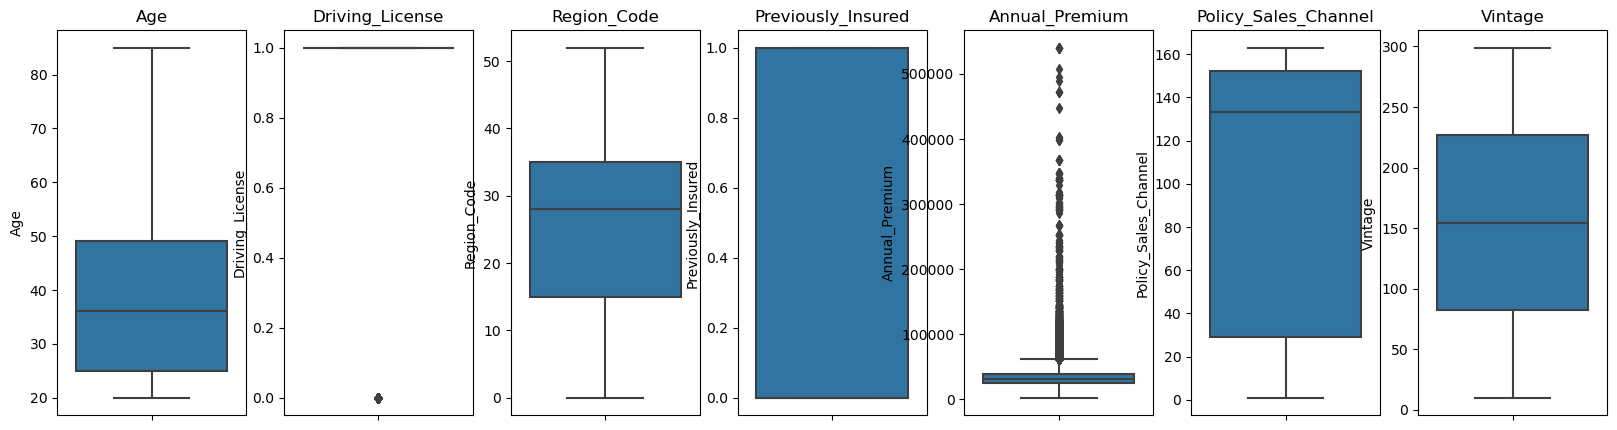

In [7]:
fig, ax  = plt.subplots(nrows = 1, ncols= 7, figsize =(20,5))

for i, col in enumerate(numerical_columns) :
    print(numerical_columns[i])
    sns.boxplot(data = train, y=col ,ax =ax[i])
    ax[i].set_title(col)
   # plt.show()

   #### Outliers found in Annual Premium    

<Axes: ylabel='Density'>

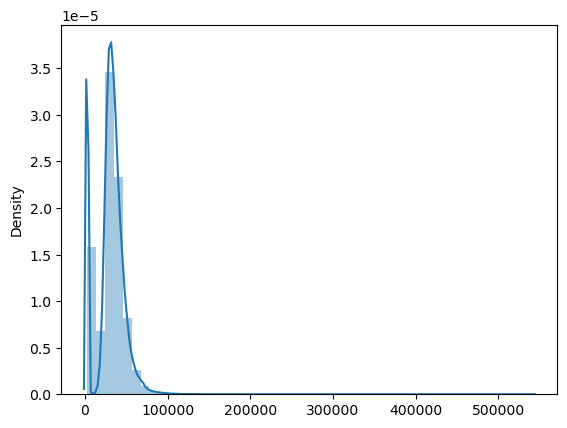

In [8]:
sns.distplot(x = train['Annual_Premium'])
#skewed Data

In [9]:
## Treating outliers through IQR Method
per_25 = train['Annual_Premium'].quantile(0.25)
per_75 = train['Annual_Premium'].quantile(0.75)

In [10]:
IQR = per_75 - per_25 
IQR

14995.0

In [11]:
upper_limit = per_75 + 1.5 * IQR
lower_limit = per_25 - 1.5 * IQR

In [12]:
print("Upper Limit : ", upper_limit," " , "Lower Limit : " ,lower_limit)

Upper Limit :  61892.5   Lower Limit :  1912.5


In [13]:
train[train['Annual_Premium'] > upper_limit].count()


id                      10320
Gender                  10320
Age                     10320
Driving_License         10320
Region_Code             10320
Previously_Insured      10320
Vehicle_Age             10320
Vehicle_Damage          10320
Annual_Premium          10320
Policy_Sales_Channel    10320
Vintage                 10320
Response                10320
dtype: int64

In [14]:
train[train['Annual_Premium'] < lower_limit].count()
# no outliers less than lower limit
# nearly 25

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [15]:
## Changing the Outliers effect on data
train['Annual_Premium'] = np.where(train['Annual_Premium']>upper_limit, upper_limit, train['Annual_Premium'])


<Axes: ylabel='Density'>

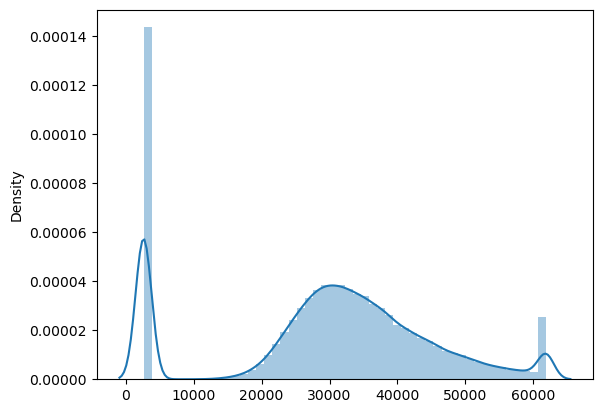

In [16]:
sns.distplot(x = train['Annual_Premium'])


<Axes: xlabel='Annual_Premium'>

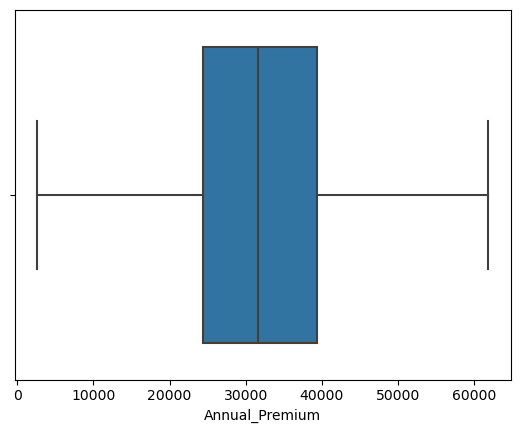

In [17]:
sns.boxplot(x = train['Annual_Premium'])


In [18]:
## outlier is treated

In [19]:
#### Pipelineing

In [20]:
#Remove unwanted columns
tgt_cols = ['Response']
ign_cols = ['id']
cat_cols = train.select_dtypes(include=['object']).columns
num_cols = train.select_dtypes(exclude=['object']).columns

In [21]:
print(cat_cols , num_cols) 

Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object') Index(['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')


In [22]:
num_cols = train.select_dtypes(exclude =['object']).drop(columns = tgt_cols + ign_cols).columns

In [23]:
train[num_cols].head(5)

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage
0,44,1,28.0,0,40454.0,26.0,217
1,76,1,3.0,0,33536.0,26.0,183
2,47,1,28.0,0,38294.0,26.0,27
3,21,1,11.0,1,28619.0,152.0,203
4,29,1,41.0,1,27496.0,152.0,39


In [24]:
train['Response'].value_counts()

Response
0    334399
1     46710
Name: count, dtype: int64

In [25]:
# Feature Engineering

In [26]:
# Categorical features preperation
categorical_transformer = Pipeline(
    
    steps = [(
        'ohe',OneHotEncoder(handle_unknown='ignore')) # categetoy encoding
        ]
)
 

In [27]:
# numerical features preprocessing
numerical_transformer = Pipeline(
    steps = [(
        'scale', StandardScaler())
     ]
    
)

In [28]:
preprocessor = ColumnTransformer(
    transformers = [
        ("num",numerical_transformer, num_cols),
        ("cat",categorical_transformer, cat_cols)
    ]
)


In [29]:
# create object for logistic Rgression
model_LR = LogisticRegression()

In [30]:
# merging the preprocessing and modelling in a pipeline
model_pipeline = Pipeline (
    steps = [
        ('preprocess',preprocessor), #Preprocess
        ('model',model_LR) # Model
    ]
)

In [31]:
X = train.drop(columns = tgt_cols + ign_cols )
X.head(2)

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183


In [32]:
y = train[tgt_cols]
y.head(2)

,Response
0,1
1,0


In [33]:
#train test Split


In [34]:
train_X, val_X , train_y, val_y = train_test_split(X,y, random_state =42 , test_size= 0.2 )
train_X.shape, val_X.shape , train_y.shape, val_y.shape
     

((304887, 10), (76222, 10), (304887, 1), (76222, 1))

In [35]:
model_pipeline.fit(train_X, train_y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object'))])),
                ('model', LogisticRegression())])

In [36]:
###model_pipeline.predict(train_X)

In [37]:
val_y.shape

(76222, 1)

In [38]:
def model_evaluvate(train_X, train_y, val_X,val_y, model_pipeline) :
    pred_train = model_pipeline.predict(train_X)
    pred_val   = model_pipeline.predict(val_X)
    lr_probs   = model_pipeline.predict_proba(val_X)
    lr_probs   = lr_probs[:, 1]
    ra_auc     = roc_auc_score(val_y, lr_probs)
    r_fpr, r_tpr, _ = roc_curve(val_y, lr_probs)

    print("=================Evaluvation Score=================")
    print('Roc auc Score' , ra_auc)
    print("=================Evaluvation Score=================")
    plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % ra_auc)


=================Evaluvation Score=================
Roc auc Score 0.8400668876267068
=================Evaluvation Score=================


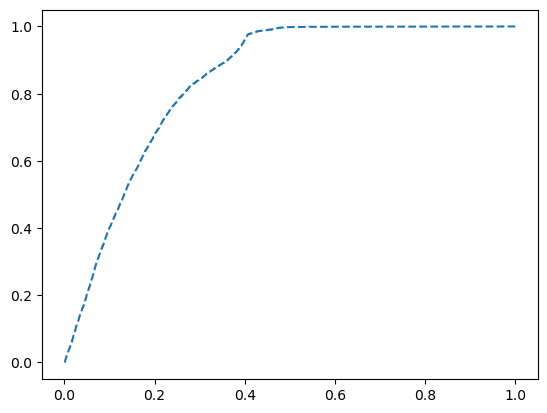

In [39]:
model_evaluvate(train_X, train_y, val_X ,val_y, model_pipeline)

In [40]:
sample['Response']= model_pipeline.predict(test)
sample.to_csv('sumission_LR.csv', index = False)

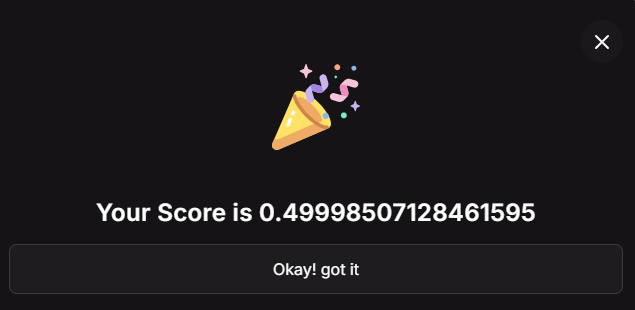

In [42]:
joblib.dump(model_pipeline,'model_LR.pkl')

['model_LR.pkl']

In [43]:
rus = RandomUnderSampler(random_state=1)
X_u_resampled, y_u_resampled = rus.fit_resample(train_X, val_y)
y_u_resampled.value_counts()

Response
0           9523
1           9523
Name: count, dtype: int64

In [44]:
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(train_X, train_y)
y_resampled.value_counts()

Response
0           267700
1           267700
Name: count, dtype: int64

In [45]:
train_X, val_X , train_y, val_y = train_test_split(X_resampled,y_resampled, random_state =42 , test_size= 0.2 )
train_X.shape, val_X.shape , train_y.shape, val_y.shape

((428320, 10), (107080, 10), (428320, 1), (107080, 1))

In [46]:
model_pipeline.fit(X_resampled, y_resampled)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object'))])),
                ('model', LogisticRegression())])

=================Evaluvation Score=================
Roc auc Score 0.8380384744289646
=================Evaluvation Score=================


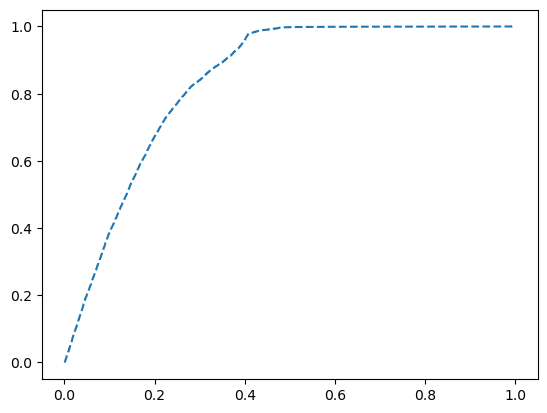

In [47]:
model_evaluvate(train_X, train_y, val_X ,val_y, model_pipeline)

In [48]:
sample['Response']= model_pipeline.predict(test)
sample.to_csv('sumission_LR_resampled.csv', index = False)

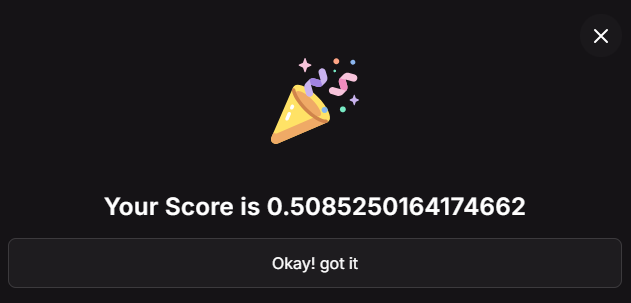

In [50]:
# Logistic Regression over sampling 
# there was no differnce in ROC auc Curve but when submitted  the score is .78

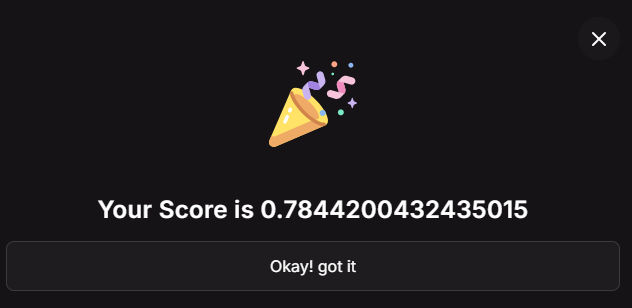

In [52]:
train_u_X, val_u_X , train_u_y, val_u_y = train_test_split(X_u_resampled,y_u_resampled, random_state =42 , test_size= 0.2 )
train_u_X.shape, val_u_X.shape , train_u_y.shape, val_u_y.shape

((15236, 10), (3810, 10), (15236, 1), (3810, 1))

In [53]:
## KNN Claddifier 
 
model_KNN = KNeighborsClassifier(n_neighbors = 40,  p = 1)
# merging the preprocessing and modelling in a pipeline
model_pipeline_KNN = Pipeline (
    steps = [
        ('preprocess',preprocessor), #Preprocess
        ('model',model_KNN) # Model
    ]
)

In [54]:
model_pipeline_KNN.fit(train_u_X, train_u_y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object'))])),
                ('model', KNeighborsClassifier(n_neighbors=40, p=1))])

=================Evaluvation Score=================
Roc auc Score 0.5007845084518592
=================Evaluvation Score=================


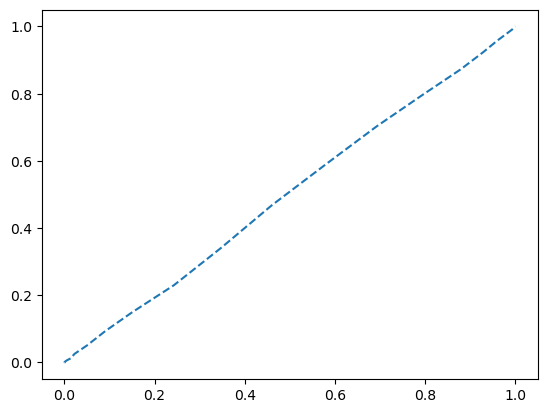

In [55]:
model_evaluvate(train_u_X, train_u_y, val_u_X ,val_u_y, model_pipeline_KNN)

In [56]:
##Classifier
model_RF = RandomForestClassifier(n_estimators=100, random_state=42)
# merging the preprocessing and modelling in a pipeline
model_pipeline_RF = Pipeline (
    steps = [
        ('preprocess',preprocessor), #Preprocess
        ('model',model_RF) # Model
    ]
)

 # Train the classifier
model_pipeline_RF.fit(train_X, train_y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object'))])),
                ('model', RandomForestClassifier(random_state=42))])

=================Evaluvation Score=================
Roc auc Score 0.9989581447975542
=================Evaluvation Score=================


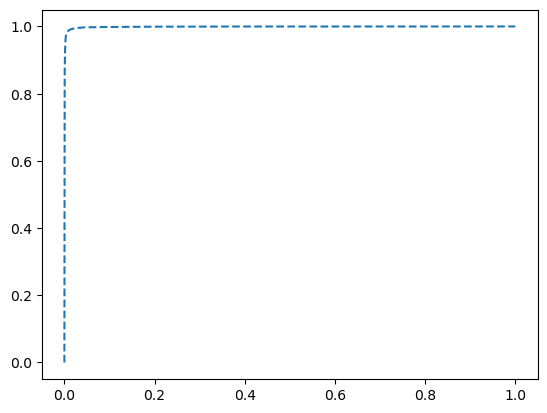

In [57]:
 model_evaluvate(train_X, train_y, val_X ,val_y, model_pipeline_RF)

In [58]:
sample['Response']= model_pipeline.predict(test)
sample.to_csv('sumission_RF_resampled.csv', index = False)

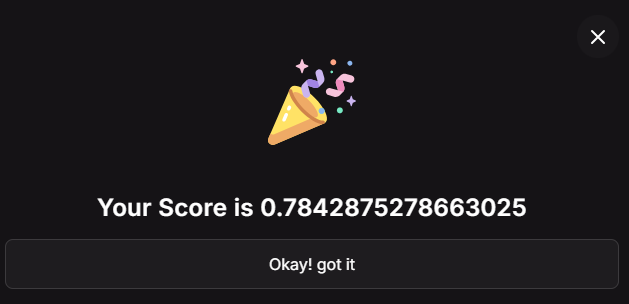

In [60]:
joblib.dump(model_pipeline,'RandomForest.pkl')

['RandomForest.pkl']

In [61]:
##Classifier
model_u_RF = RandomForestClassifier(n_estimators=100, random_state=42)
# merging the preprocessing and modelling in a pipeline
model_pipeline_u_RF = Pipeline (
    steps = [
        ('preprocess',preprocessor), #Preprocess
        ('model',model_u_RF) # Model
    ]
)

 # Train the classifier
model_pipeline_RF.fit(train_u_X, train_u_y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object'))])),
                ('model', RandomForestClassifier(random_state=42))])

=================Evaluvation Score=================
Roc auc Score 0.4934627051240223
=================Evaluvation Score=================


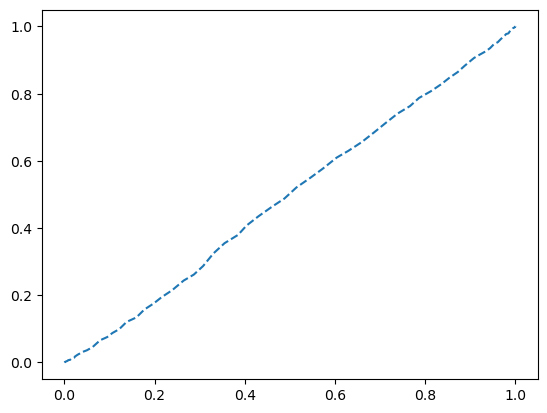

In [62]:
 model_evaluvate(train_u_X, train_u_y, val_u_X ,val_u_y, model_pipeline_RF)

In [63]:
Bagging_Clf = BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=100, random_state=42),n_estimators=100,random_state = 42)

model_pipeline_u_BG = Pipeline (
    steps = [
        ('preprocess',preprocessor), #Preprocess
        ('model',Bagging_Clf) # Model 
    ]
)


In [64]:
model_pipeline_u_BG.fit(train_u_X,train_u_y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Annual_Premium', 'Policy_Sales_Channel', 'Vintage'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Gender', 'Vehicle_Age', 'Vehicle_Damage'], dtype='object'))])),
                ('model',
                 BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),
                                   n_estimators=100, random_state=42))])

=================Evaluvation Score=================
Roc auc Score 0.4892701178057792
=================Evaluvation Score=================


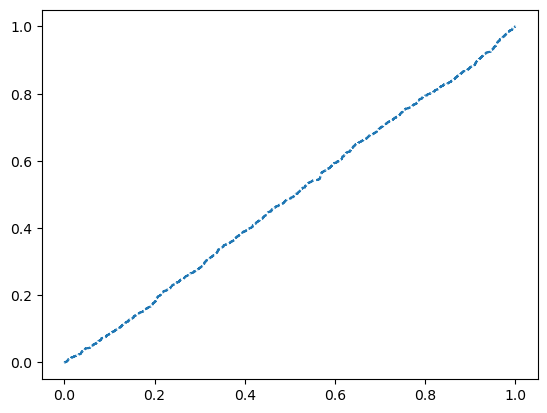

In [65]:
 model_evaluvate(train_u_X, train_u_y, val_u_X ,val_u_y, model_pipeline_u_BG)